##### 🏢 Previsão de Preços de Apartamentos em São Paulo: Um Estudo Baseado em Dados Imobiliários Reais

- Este projeto tem como objetivo desenvolver um modelo de Machine Learning capaz de prever o preço de venda de apartamentos residenciais localizados na cidade de São Paulo. Utilizando um conjunto de dados (2019) reais do mercado imobiliário, a análise busca identificar os principais fatores que influenciam os valores dos apartamentos e aplicar técnicas de aprendizado de máquina para criar um modelo preditivo preciso e escalável. A motivação por trás deste trabalho é fornecer uma ferramenta que auxilie compradores, vendedores, corretores e investidores na tomada de decisões mais embasadas, reduzindo a subjetividade e aumentando a transparência nas negociações imobiliárias.

- O processo inclui etapas fundamentais como a coleta e limpeza dos dados, análise exploratória, engenharia de atributos, seleção e validação de modelos, e avaliação dos resultados com métricas apropriadas. Além disso, o projeto é cuidadosamente documentado para garantir reprodutibilidade, facilitar futuras melhorias e servir como base para projetos semelhantes em outras regiões ou setores. Ao final, espera-se que o modelo desenvolvido possa oferecer estimativas confiáveis e contextualizadas ao perfil de cada imóvel, levando em conta variáveis como localização, metragem, número de quartos, vagas, entre outros.



#### 1. Importar Bibliotecas e Base de Dados

In [2]:
import pandas as pd
import folium
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import unicodedata

pd.set_option('display.max_rows', 10)
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv(r'database/sao-paulo-properties-april-2019.csv')
display(df.head())
print(f'Total de Linhas: {len(df)}')

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
0,930,220,47,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.543138,-46.479486
1,1000,148,45,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.550239,-46.480718
2,1000,100,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.542818,-46.485665
3,1000,200,48,2,2,1,1,0,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.547171,-46.483014
4,1300,410,55,2,2,1,1,1,0,0,0,Artur Alvim/São Paulo,rent,apartment,-23.525025,-46.482436


Total de Linhas: 13640


##### 🔍 Percebe-se que existem 2 tipos de anúncio: Venda e Locação, que tem uma diferença muito grande de preços, pensando no meu objetivo, irei manter somente os dados referente a venda

In [4]:
df = df[df['Negotiation Type'] == 'sale']
display(df.head())
print(f'Total de Linhas: {len(df)}')

,Price,Condo,Size,Rooms,Toilets,Suites,Parking,Elevator,Furnished,Swimming Pool,New,District,Negotiation Type,Property Type,Latitude,Longitude
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552129,-46.692244
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.551613,-46.699106
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo,sale,apartment,-23.547687,-46.692594
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552590,-46.691104
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.553087,-46.697890


Total de Linhas: 6412


#####  Traduzir colunas para facilitar no futuro 📖

In [5]:
df = df.rename(columns={'Price': 'Preco', 'Condo': 'taxa_condominio', 'Rooms': 'Quartos', 'Toilets': 'Banheiros', 'Parking': 'Vagas',
                        'Elevator': 'Elevador', 'Furnished': 'Mobiliado', 'Swimming Pool': 'Piscina', 'New': 'Novo', 'District': 'Bairro', 
                       'Size': 'Area(m²)'})


display(df.head())

,Preco,taxa_condominio,Area(m²),Quartos,Banheiros,Suites,Vagas,Elevador,Mobiliado,Piscina,Novo,Bairro,Negotiation Type,Property Type,Latitude,Longitude
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552129,-46.692244
4902,1990000,2400,164,4,5,2,3,1,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.551613,-46.699106
4903,720000,700,70,2,2,1,1,1,0,1,1,Vila Madalena/São Paulo,sale,apartment,-23.547687,-46.692594
4904,1680000,1580,155,3,5,3,2,1,0,1,0,Vila Madalena/São Paulo,sale,apartment,-23.552590,-46.691104
4905,1200000,900,56,2,2,1,2,0,1,1,0,Vila Madalena/São Paulo,sale,apartment,-23.553087,-46.697890


- A coluna Negotiation Type (Tipo de Negocição) não é mais necessária, tenho certeza de que ela não ajudará em absolutamente nada na previsão de preços.

- A coluna Property Type (Tipo de Propriedade) também não será necessária, já que a base de dados se refere a apartamentos, logo todos os dados são de propriedades iguais (apartamentos.)

In [6]:
df = df.drop(['Negotiation Type', 'Property Type'], axis=1)
display(df.head(1))

,Preco,taxa_condominio,Area(m²),Quartos,Banheiros,Suites,Vagas,Elevador,Mobiliado,Piscina,Novo,Bairro,Latitude,Longitude
4901,732600,1000,74,1,2,1,2,1,0,1,0,Vila Madalena/São Paulo,-23.552129,-46.692244


#### Tratar a coluna de Bairro 🏚️

- Os dados da coluna Bairro seguem como: 'Vila Madalena/São Paulo', irei manter somente o bairro, já que todos os imóveis pertencem a cidade de São Paulo.

In [7]:
df['Bairro'] = df['Bairro'].str.split('/').str[0]
print(df['Bairro'].value_counts())

Bairro
Casa Verde        149
Bom Retiro        147
Brooklin          139
Bela Vista        136
Moema             130
                 ... 
Cachoeirinha       31
Perus              30
Freguesia do Ó     30
Jaraguá            22
Iguatemi           20
Name: count, Length: 96, dtype: int64


#### Checar as estatísticas do DataFrame 📊

- Checar e Tratar os Dados Nulos

In [8]:
print(df.isnull().sum())

Preco              0
taxa_condominio    0
Area(m²)           0
Quartos            0
Banheiros          0
                  ..
Piscina            0
Novo               0
Bairro             0
Latitude           0
Longitude          0
Length: 14, dtype: int64


- Checar os tipos de dados em cada coluna

In [9]:
print(df.iloc[0])
print('-'*60)
print(df.dtypes)

Preco                     732600
taxa_condominio             1000
Area(m²)                      74
Quartos                        1
Banheiros                      2
                       ...      
Piscina                        1
Novo                           0
Bairro             Vila Madalena
Latitude              -23.552129
Longitude             -46.692244
Name: 4901, Length: 14, dtype: object
------------------------------------------------------------
Preco                int64
taxa_condominio      int64
Area(m²)             int64
Quartos              int64
Banheiros            int64
                    ...   
Piscina              int64
Novo                 int64
Bairro              object
Latitude           float64
Longitude          float64
Length: 14, dtype: object


- Checar as estatísticas do DataFrame

In [10]:
display(df.describe())

,Preco,taxa_condominio,Area(m²),Quartos,Banheiros,Suites,Vagas,Elevador,Mobiliado,Piscina,Novo,Latitude,Longitude
count,6.412000e+03,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000
mean,6.086241e+05,537.349813,78.611042,2.320805,2.037742,0.931535,1.326575,0.415471,0.117280,0.539457,0.032283,-22.127513,-43.705547
std,7.404515e+05,624.632473,50.872359,0.714743,0.917844,0.772615,0.751658,0.492841,0.321779,0.498480,0.176765,5.756660,11.271783
min,4.200000e+04,0.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-46.734483,-49.337815
25%,2.500000e+05,150.000000,50.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-23.592848,-46.673526
50%,3.800000e+05,400.000000,62.000000,2.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-23.549693,-46.628506
75%,6.790000e+05,700.000000,87.000000,3.000000,2.000000,1.000000,2.000000,1.000000,0.000000,1.000000,0.000000,-23.512534,-46.533612
max,1.000000e+07,8920.000000,620.000000,6.000000,7.000000,6.000000,7.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000


### Análise Exploratória e Tratar Outliers 🚀

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir

<Axes: >

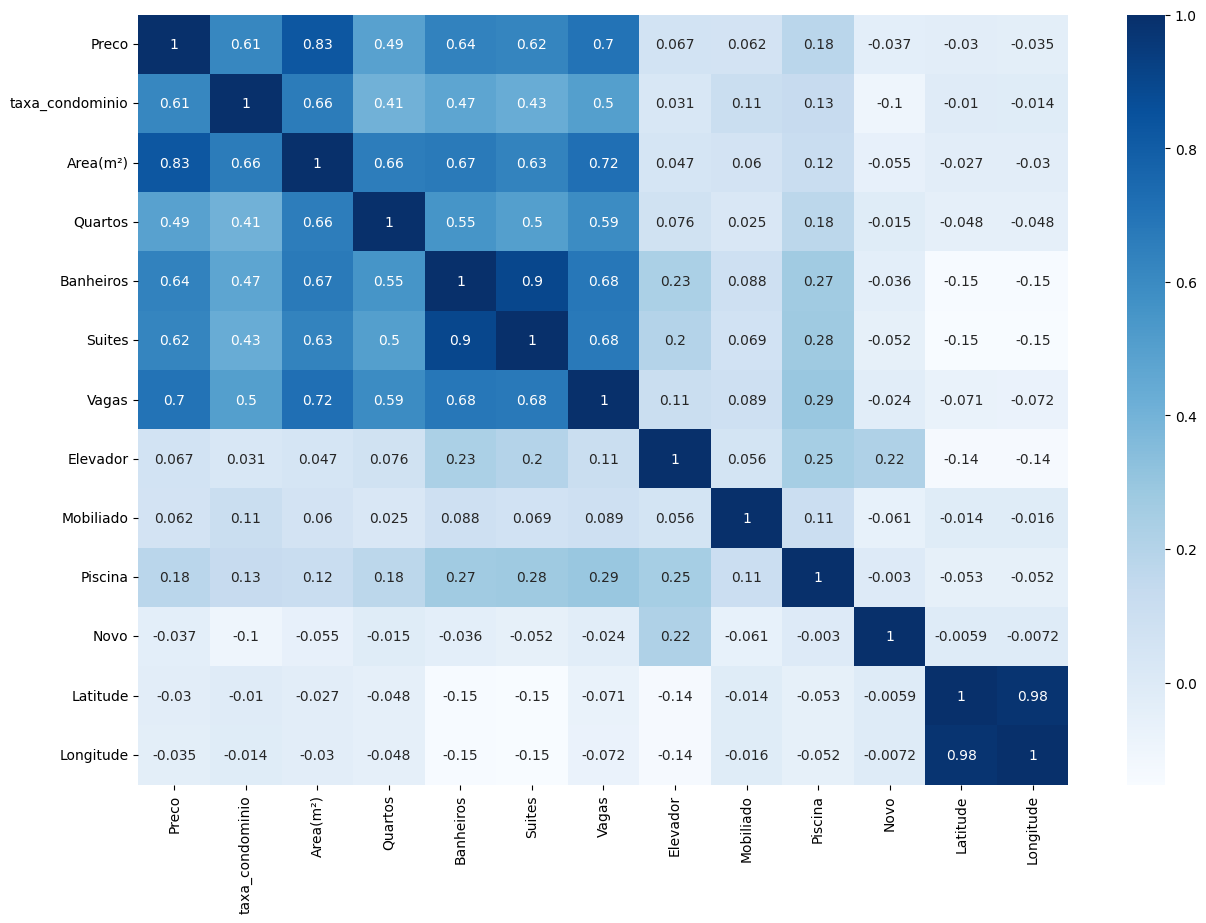

In [11]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='Blues')

#### Funções para tratar outliers 🎯

In [12]:
def calcular_limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = stats.iqr(coluna)
    limite_inferior = q1 - 1.5 * amplitude
    limite_superior = q3 + 1.5 * amplitude
    return limite_inferior, limite_superior


def diagrama_caixa(coluna):
    fig, (ax1, ax2)= plt.subplots(1,2)
    fig.set_size_inches(15,5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(calcular_limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)


def histograma(coluna):
    plt.figure(figsize=(15,5))
    sns.histplot(data=df, x=coluna, element='bars')    


def delete_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inf, lim_sup = calcular_limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup), :]    
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas


def grafico_barras(coluna):
    plt.figure(figsize=(15, 5))
    # Gerando uma paleta de cores
    palette = sns.color_palette("dark", len(coluna.value_counts()))
    # Criando o gráfico de barras
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts(), palette=palette)
    ax.set_xlim(calcular_limites(coluna))
    plt.show()


def diagrama_caixa_com_dispersao(coluna):
    plt.figure(figsize=(15,5))
    sns.boxplot(x=coluna, color='lightblue')
    sns.stripplot(x=coluna, color='red', alpha=0.3, jitter=True)
    plt.title("Boxplot com Outliers Destacados")
    plt.show()


def grafico_outliers_interativo(df, nome_coluna):
    coluna = df[nome_coluna]
    lim_inf, lim_sup = calcular_limites(coluna)
    
    outliers = df[(coluna < lim_inf) | (coluna > lim_sup)].copy()
    outliers['Tipo'] = 'Outlier'
    
    fig = px.strip(outliers, x=nome_coluna, title=f'Outliers Interativos - {nome_coluna}',
                   color='Tipo', hover_data=df.columns)

    # Adiciona linhas de referência para limites inferior e superior
    fig.add_vline(x=lim_inf, line_dash="dash", line_color="blue", annotation_text="Limite Inferior")
    fig.add_vline(x=lim_sup, line_dash="dash", line_color="green", annotation_text="Limite Superior")
    
    fig.update_traces(jitter=0.3, marker=dict(size=10, color='red'))
    fig.update_layout(width=1000, height=400)
    fig.show()

    print(f"Total de outliers encontrados em '{nome_coluna}': {outliers.shape[0]}")
    return outliers

##### Coluna 'Preço' 💰

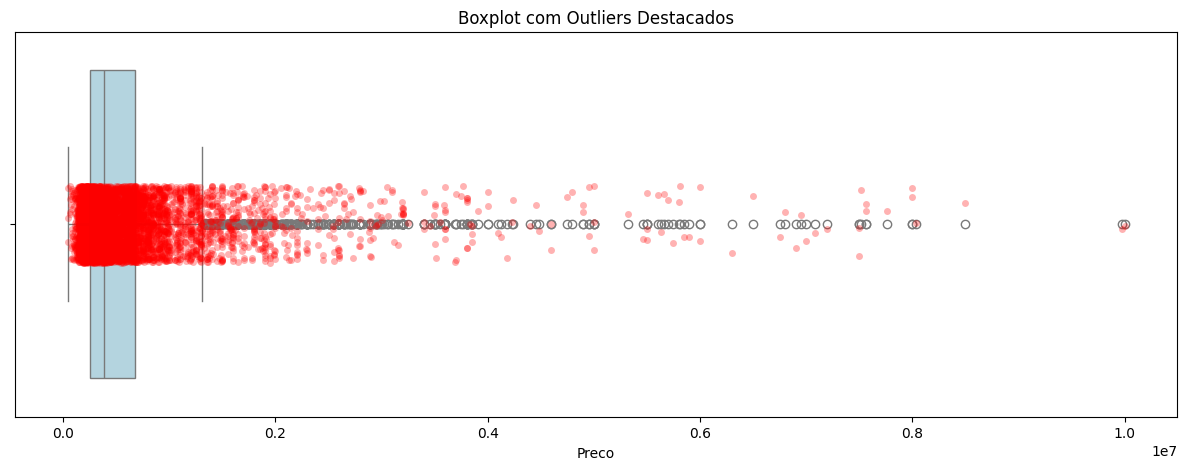

In [13]:
diagrama_caixa_com_dispersao(df['Preco'])

In [14]:
outliers_preco = grafico_outliers_interativo(df, 'Preco')

Total de outliers encontrados em 'Preco': 519


#### 🔍 1. Análise de outliers por região

- Em vez de considerar outliers globalmente, vamos dividir os dados por bairro ou região e analisar os outliers localmente. Um imóvel de R$ 4 milhões nos Jardins ou em Higienópolis não é outlier, mas em Guaianases talvez seja.

#### 🏠 2. Irei usar variáveis auxiliares no cálculo de outliers

- Preço absoluto pode ser uma métrica "injusta". Tentemos usar:

- Preço por metro quadrado (preco_venda / metragem)


Essas métricas ajustadas ajudam a encontrar desvios mais significativos em relação ao padrão esperado.

In [15]:
df['preco_m2'] = df['Preco'] / df['Area(m²)']

df['outlier'] = False

for bairro, sub_df in df.groupby('Bairro'):
    q1 = sub_df['preco_m2'].quantile(0.25)
    q3 = sub_df['preco_m2'].quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr

    cond = (df['Bairro'] == bairro) & (
        (df['preco_m2'] < limite_inferior) | (df['preco_m2'] > limite_superior)
    )
    df.loc[cond, 'outlier'] = True


print(f"Total de outliers identificados com base no preço por m² por bairro: {df['outlier'].sum()}")

Total de outliers identificados com base no preço por m² por bairro: 179


 - 179 outliers com base no preço por m² por bairro já é um filtro muito mais justo do que simplesmente olhar o preço total!

#### 📊 Gráfico de dispersão (scatter plot)

Mostrar o preco_venda vs area_util, colorindo os outliers para identificar visualmente:

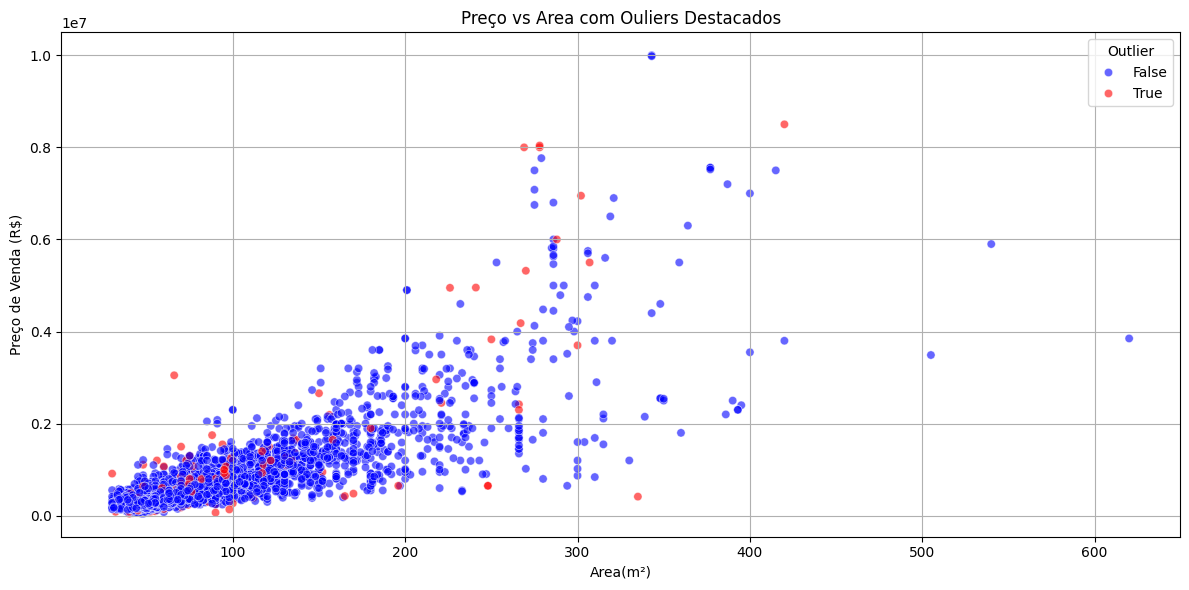

In [16]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=df, x='Area(m²)', y='Preco', hue='outlier', palette={True: 'red', False: 'blue'}, alpha=0.6)
plt.title('Preço vs Area com Ouliers Destacados')
plt.xlabel('Area(m²)')
plt.ylabel('Preço de Venda (R$)')
plt.legend(title='Outlier')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 📊 Boxplot por bairro com e sem outliers

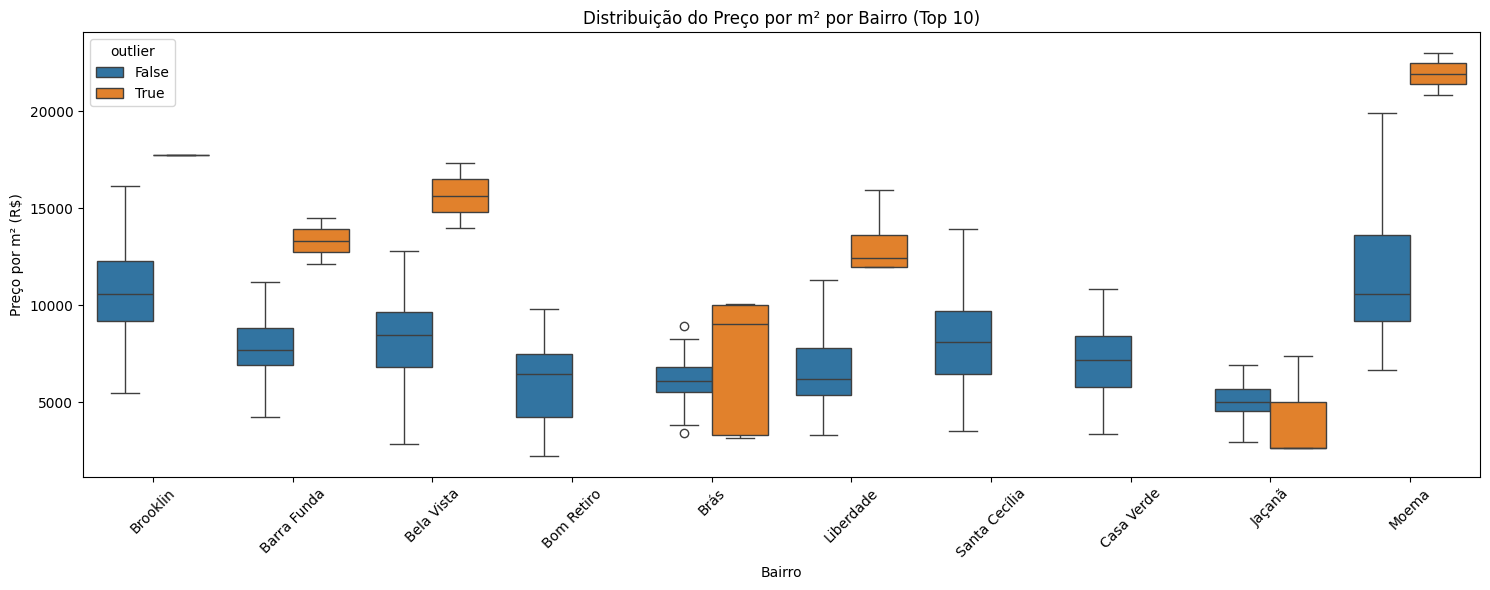

In [17]:
plt.figure(figsize=(15, 6))
# Usando uma amostra de bairros se houver muitos
bairros_mais_comuns = df['Bairro'].value_counts().head(10).index
sns.boxplot(data=df[df['Bairro'].isin(bairros_mais_comuns)], x='Bairro', y='preco_m2', hue='outlier')
plt.xticks(rotation=45)
plt.title('Distribuição do Preço por m² por Bairro (Top 10)')
plt.ylabel('Preço por m² (R$)')
plt.tight_layout()
plt.show()


##### ✅ Irei separar esses outliers em um outro DataFrame. Essa é uma excelente prática, separar os dados que você considera outliers em um novo DataFrame para não alterar ou “sujar” a base original. Isso te dá flexibilidade para análises separadas, treinar modelos com ou sem outliers, e até revisar esses casos com calma depois.

In [18]:
df_outliers = df[df['outlier'] == True].copy()

# Cria um novo DataFrame sem os outliers
df_sem_outliers = df[df['outlier'] == False].copy()
df_sem_outliers = df_sem_outliers.drop(columns=['preco_m2', 'outlier'])

#### Coluna Área 📐

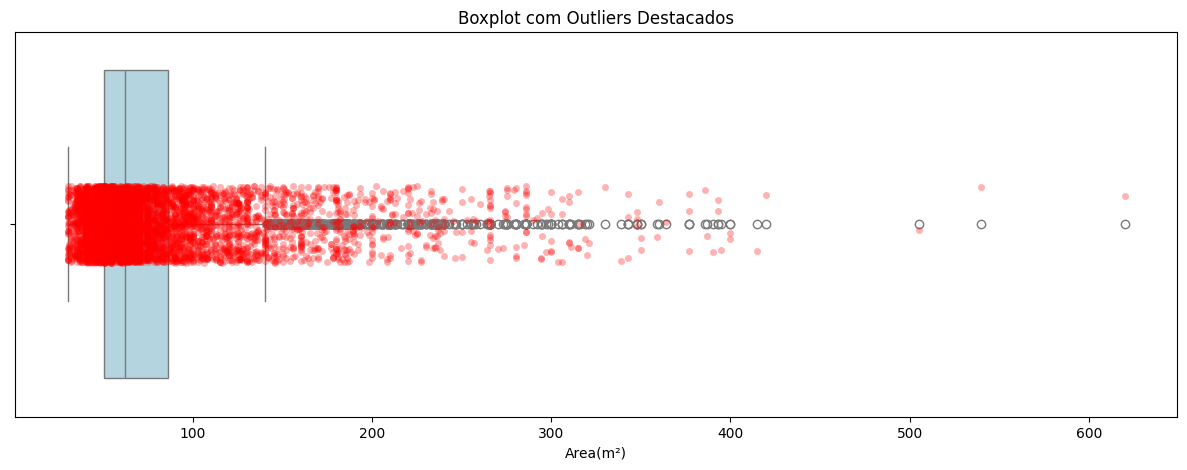

In [19]:
diagrama_caixa_com_dispersao(df_sem_outliers['Area(m²)'])

In [20]:
outliers_area = grafico_outliers_interativo(df_sem_outliers, 'Area(m²)')

Total de outliers encontrados em 'Area(m²)': 558


- Acredito que a Área possa ter um impacto fundamental na parte de precificação, então tenho de tomar bastante cuidado com a exclusão de valores. Irei nesse momento, manter esses dados que estão sendo considerados outliers.

#### Coluna Banheiros 🚽

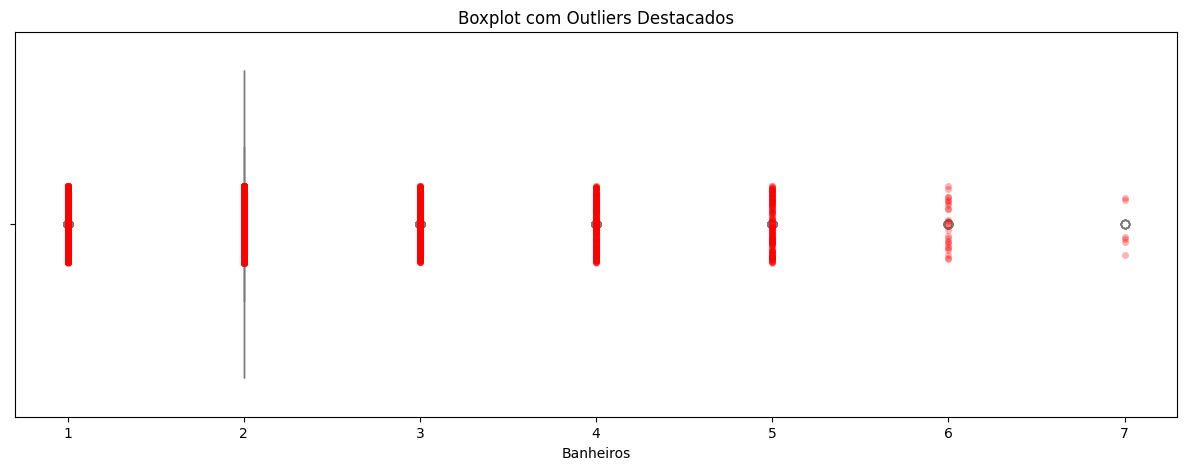

In [21]:
diagrama_caixa_com_dispersao(df_sem_outliers['Banheiros'])

In [22]:
outliers_banheiros = grafico_outliers_interativo(df_sem_outliers, 'Banheiros')

Total de outliers encontrados em 'Banheiros': 2430


- Mesmo caso da coluna Área!

#### Coluna Quartos 💤

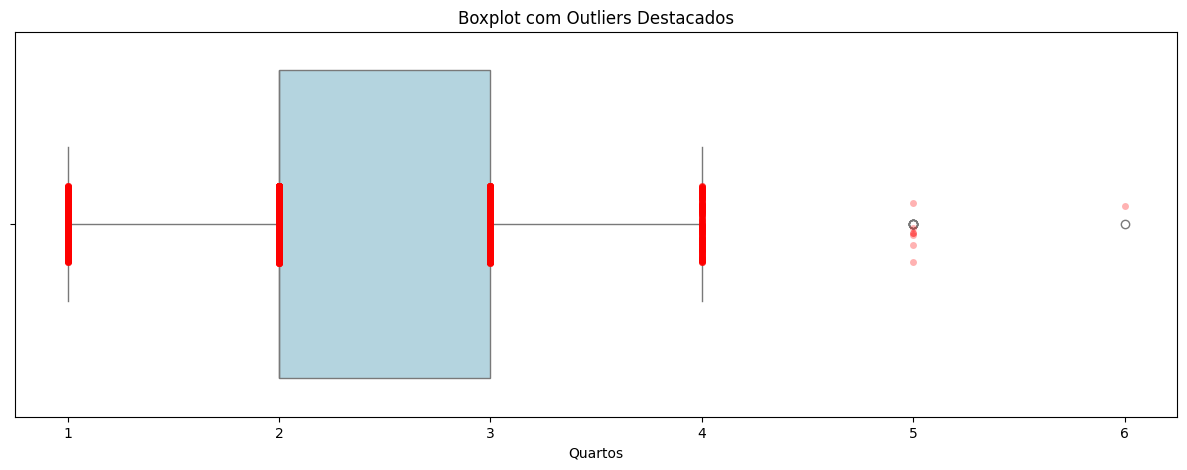

In [23]:
diagrama_caixa_com_dispersao(df_sem_outliers['Quartos'])

In [24]:
outliers_quartos = grafico_outliers_interativo(df_sem_outliers, 'Quartos')

Total de outliers encontrados em 'Quartos': 8


- Aqui é um caso um pouco diferente dos outros dois, tenho 8 valores que estão com um número de quartos bem elevados, pra mim faz sentido fazer a remoção dos mesmos, já que são apenas 8 linhas.

In [25]:
df_sem_outliers, linhas_removidas = delete_outliers(df_sem_outliers, 'Quartos')
print('{} Linhas Removidas'.format(linhas_removidas))

8 Linhas Removidas


#### Coluna suites 🛏️

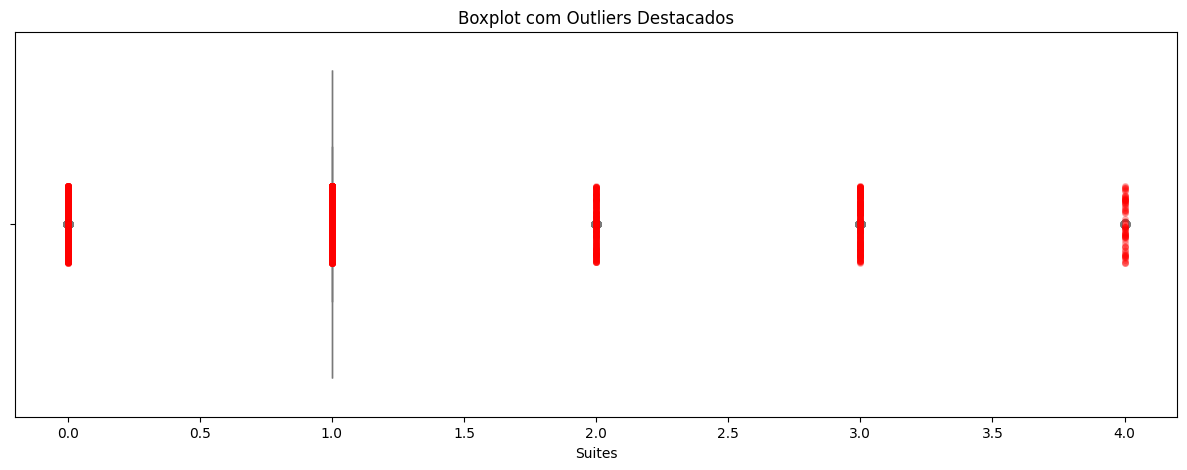

In [26]:
diagrama_caixa_com_dispersao(df_sem_outliers['Suites'])

In [27]:
outliers_suites = grafico_outliers_interativo(df_sem_outliers, 'Suites')

Total de outliers encontrados em 'Suites': 2161


- Segue a lógica das colunas Banheiros e Área.

#### Coluna Vagas na Garagem 🚗

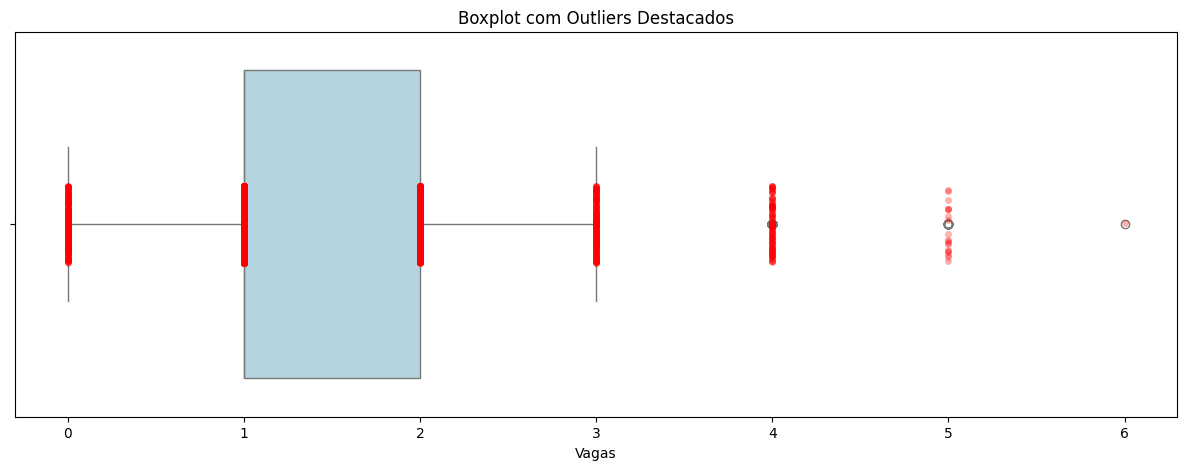

In [28]:
diagrama_caixa_com_dispersao(df_sem_outliers['Vagas'])

In [29]:
outliers_vagas = grafico_outliers_interativo(df_sem_outliers, 'Vagas')

Total de outliers encontrados em 'Vagas': 140


- Irei optar por remover esses outliers, não é muito comum encontrarmos apartamentos com 4 a 6 vagas na garagaem por morador.

In [30]:
df_sem_outliers, linhas_removidas = delete_outliers(df_sem_outliers, 'Vagas')
print('{} Linhas Removidas'.format(linhas_removidas))

140 Linhas Removidas


#### Visualização de Mapa das Propriedades

In [31]:
# Cria o mapa centralizado na média das coordenadas
mapa = folium.Map(location=[df_sem_outliers['Latitude'].mean(), df_sem_outliers['Longitude'].mean()], zoom_start=12)

# Adiciona os pontos no mapa
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=row['Preco'] / 100000,  # Ajusta tamanho do círculo
        popup=f"Preço: R${row['Preco']:,}",
        color='blue',
        fill=True,
        fill_color='blue'
    ).add_to(mapa)

# Salva o mapa em HTML
mapa.save('mapa.html')

In [32]:
fig = px.scatter_mapbox(
    df_sem_outliers,
    lat='Latitude',
    lon='Longitude',
    color='Preco',       # muda a cor baseado no preço
    size='Preco',        # muda o tamanho baseado no preço
    size_max=15,         # tamanho máximo dos pontos
    zoom=10,
    mapbox_style='open-street-map'
)

fig.show()

#### Coluna Bairro 🌇

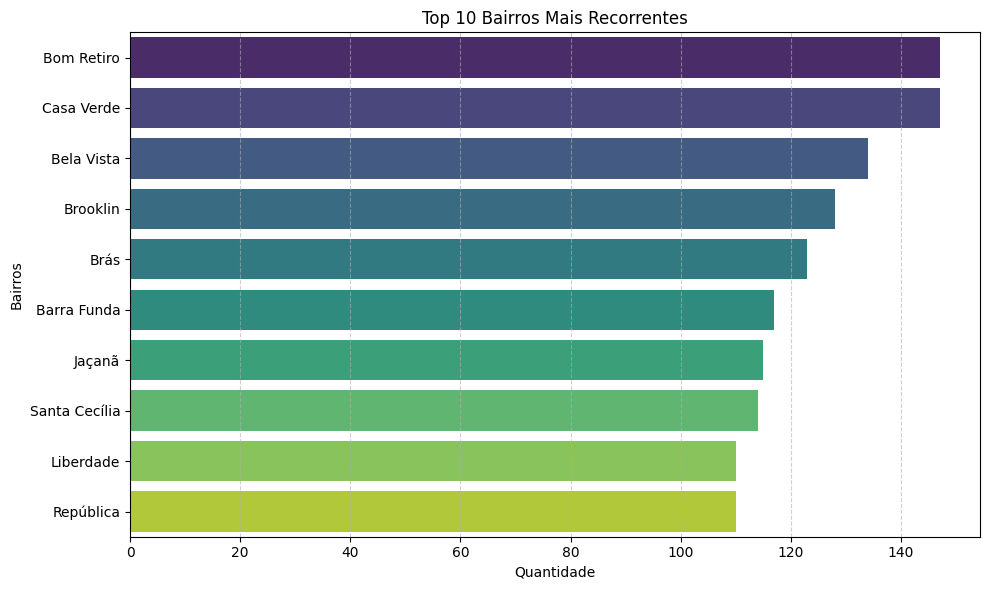

In [33]:
bairro_counts = df_sem_outliers['Bairro'].value_counts().nlargest(10)

plt.figure(figsize=(10,6))
sns.barplot(x=bairro_counts.values, y=bairro_counts.index, palette='viridis')
plt.xlabel('Quantidade')
plt.ylabel('Bairros')
plt.title('Top 10 Bairros Mais Recorrentes')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [34]:
# Filtra os 10 bairros mais frequentes
top_bairros = df_sem_outliers['Bairro'].value_counts().nlargest(10).index

# Filtra o DataFrame
df_top_bairros = df_sem_outliers[df_sem_outliers['Bairro'].isin(top_bairros)]

# Calcula o preço médio
media_preco = df_top_bairros.groupby('Bairro')['Preco'].mean().sort_values(ascending=False).reset_index()

# Gráfico interativo
fig = px.bar(
    media_preco,
    x='Preco',
    y='Bairro',
    orientation='h',
    color='Preco',
    color_continuous_scale='viridis',
    labels={'Preco': 'Preço Médio (R$)', 'Bairro': 'Bairro'},
    title='Preço Médio de Imóveis nos 10 Bairros mais Frequentes'
)

fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

#### Encoding ⌨️

- Ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true ou false e etc...)

- Features de categoria (features em que os valores da coluna são texto). Podemos utilizar o método de encoding de variáveis dumming.

#### ✅ Alternativas recomendadas para bairro:

1. Target Encoding (ou Mean Encoding)

Substitui cada bairro pela média do preço de venda dentro daquele bairro.

#### 🚫 Problemas com One-Hot Encoding em alta cardinalidade:

Cria diversas novas colunas, o que:

- Aumenta a dimensionalidade do dataset.

- Pode causar sparsidade (muitos zeros).

- Impacta negativamente o desempenho de modelos e memória.



In [35]:
# Cópia do DataFrame
df_encoded = df_sem_outliers.copy()
df_encoded['bairro_encoded'] = np.nan

# KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, val_idx in kf.split(df_encoded):
    train_data = df_encoded.iloc[train_idx]
    val_data = df_encoded.iloc[val_idx]
    
    # Média do preço por bairro no conjunto de treino
    mean_encoding = train_data.groupby('Bairro')['Preco'].mean()
    
    # Codifica o conjunto de validação
    df_encoded.iloc[val_idx, df_encoded.columns.get_loc('bairro_encoded')] = val_data['Bairro'].map(mean_encoding).values

# Preenche os NaNs com a média geral
df_encoded['bairro_encoded'].fillna(df_encoded['bairro_encoded'].mean(), inplace=True)

# Verifica
print(df_encoded[['Bairro', 'bairro_encoded']].head())

             Bairro  bairro_encoded
4901  Vila Madalena    1.223409e+06
4902  Vila Madalena    1.193484e+06
4903  Vila Madalena    1.193484e+06
4904  Vila Madalena    1.060350e+06
4906  Vila Madalena    1.060350e+06


In [36]:
mapa_encoding = df_encoded[['Bairro', 'bairro_encoded']].drop_duplicates().set_index('Bairro')['bairro_encoded'].to_dict()
mapa_reverso = {v: k for k, v in mapa_encoding.items()}

df_encoded.drop(columns=['Bairro', 'Latitude', 'Longitude'], inplace=True)

#### Modelo de Previsão 🤖

In [37]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    rmse = np.sqrt(mean_squared_error(y_teste, previsao))
    mae = mean_absolute_error(y_teste, previsao)
    mse = mean_squared_error(y_teste, previsao)
    mape = np.mean(np.abs((y_teste - previsao) / y_teste)) * 100

    return (
        f"Modelo {nome_modelo}:\n"
        f"R²: {r2:.2%}\n"
        f"RMSE: {rmse:.2f}\n"
        f"MAE: {mae:.2f}\n"
        f"MSE: {mse:.2f}\n"
        f"MAPE: {mape:.2f}%\n"
    )

In [38]:
model_rf = RandomForestRegressor()
model_lr = LinearRegression()
model_et = ExtraTreesRegressor()
model_xgb = XGBRegressor()
model_gradient = GradientBoostingRegressor()
model_lightgbm = LGBMRegressor()

models = {'RandomForest': model_rf,
          'LinearRegression': model_lr,
          'ExtraTrees': model_et,
          'XgBoost': model_xgb,
          'GradientBoost': model_gradient
}


y = df_encoded['Preco']
X = df_encoded.drop(['Preco'], axis=1)

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

for nome_modelo, modelo in models.items():
    modelo.fit(X_train, y_train)
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))


Modelo RandomForest:
R²: 86.05%
RMSE: 180024.54
MAE: 85247.39
MSE: 32408836018.62
MAPE: 14.31%

Modelo LinearRegression:
R²: 80.20%
RMSE: 214471.30
MAE: 117127.86
MSE: 45997938785.94
MAPE: 24.13%

Modelo ExtraTrees:
R²: 87.18%
RMSE: 172538.41
MAE: 80825.19
MSE: 29769503782.52
MAPE: 13.74%

Modelo XgBoost:
R²: 85.29%
RMSE: 184844.15
MAE: 89352.73
MSE: 34167360556.75
MAPE: 15.08%

Modelo GradientBoost:
R²: 84.06%
RMSE: 192438.50
MAE: 94329.42
MSE: 37032574443.76
MAPE: 16.52%



#### 🚀Aplicar Cross-Validation

In [40]:
from sklearn.model_selection import cross_val_score

modelos_cv = {
    'RandomForest': model_rf,
    'XGBoost': model_xgb,
    'ExtraTrees': model_et,
    'GradientBoost': model_gradient,
    'LinearRegression': model_lr
}

for nome, modelo in modelos_cv.items():
    scores = cross_val_score(modelo, X, y, cv=5, scoring='r2')
    print(f'{nome}: R² médio: {np.mean(scores)*100:.2f}% | Desvio: {np.std(scores)*100:.2f}%')

RandomForest: R² médio: 86.69% | Desvio: 2.06%
XGBoost: R² médio: 85.37% | Desvio: 3.17%
ExtraTrees: R² médio: 86.12% | Desvio: 2.63%
GradientBoost: R² médio: 85.92% | Desvio: 2.15%
LinearRegression: R² médio: 78.36% | Desvio: 5.05%


#### 💡 Pontos fortes do RandomForest:

- Melhor R² médio (86.69%), ou seja, explica mais da variabilidade dos dados do que os outros modelos.

- Segundo melhor R² individual (86.05%) na primeira avaliação, ficando atrás apenas do ExtraTrees.

- Boa estabilidade, com desvio padrão de R² menor do que o XGBoost e LinearRegression.

- Bons resultados em RMSE, MAE e MAPE, indicando baixo erro absoluto e percentual.

#### ⚖️ Comparação com os outros modelos:

- ExtraTrees teve o melhor desempenho individual (87.18%) e o melhor MAPE (13.74%), mas no cross-validation o R² médio foi um pouco inferior ao - RandomForest (86.12% vs 86.69%) e com maior desvio (2.63%).

- XGBoost teve uma boa performance, mas foi menos estável (desvio de 3.17%) e apresentou métricas de erro piores que RandomForest e ExtraTrees.

- GradientBoost também foi sólido, mas ficou consistentemente atrás dos três anteriores em quase todas as métricas.

- LinearRegression foi claramente inferior em todos os aspectos, com menor R² e maiores erros.

#### ✅ Conclusão final:

O RandomForest foi o modelo que apresentou melhor equilíbrio entre acurácia e estabilidade, sendo a escolha mais confiável.

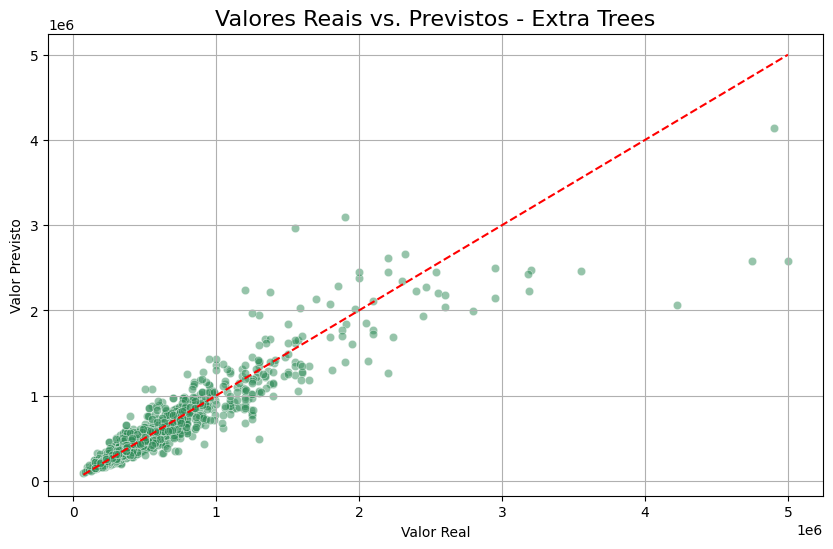

In [44]:
# Previsões do modelo Extra Trees
y_pred_et = model_rf.predict(X_test)

# Tamanho do gráfico
plt.figure(figsize=(10, 6))

# Gráfico de dispersão
sns.scatterplot(x=y_test, y=y_pred_et, alpha=0.5, color='seagreen')

# Linha de referência (ideal: previsão = valor real)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')

plt.title('Valores Reais vs. Previstos - Extra Trees', fontsize=16)
plt.xlabel('Valor Real')
plt.ylabel('Valor Previsto')
plt.grid(True)

plt.show()


#### Deploy do Projeto 🤖

    - Passo 1 -> Criar arquivo do modelo (joblib)
    - Passo 2 -> Escolher a forma de deploy


Irei optar por fazer o deploy usando o streamlit ou o Tkinter.


In [45]:
X['Preco'] = y
X.to_csv('dados.csv')

In [46]:
import joblib

joblib.dump(model_rf, 'modelo_randomf.joblib')

['modelo_randomf.joblib']

In [47]:
# Salva esse dicionário
joblib.dump(mapa_encoding, 'mapa_encoding.joblib')

['mapa_encoding.joblib']

In [48]:
print(df_encoded.columns)

Index(['Preco', 'taxa_condominio', 'Area(m²)', 'Quartos', 'Banheiros',
       'Suites', 'Vagas', 'Elevador', 'Mobiliado', 'Piscina', 'Novo',
       'bairro_encoded'],
      dtype='object')
